# Практическое задание 4: Деревья решений

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)

**<font color='red'>Внимание!</font> Если Вы выполняете данное задание в google colab и предыдущий код выполнился с ошибкой (файл не скачался), то:**

a) Попробуйте перезапустить ядро;

б) Если не помогло, то скачайте файл вручную.

Для этого:

1. Перейдите по ссылке, указанной этом в сообщении об ошибке.
1. Скачайте файл вручную на локальный компьютер.
1. Нажмите на иконку папки в левой верхней части данного окна.
1. Вручную загрузите файл в корневую директорию (перетащив файл на область с файлами или нажав ПКМ -> загрузить).

In [ ]:
# ! pip install -r requirements_small.txt

-----------
<font color="white" style="opacity:0.2023"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как деревья решений. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

**<font color='red'>Внимание!</font> При решении задач разрешается использовать ``n_jobs`` для ускорения обучения.**

**<font color='red'>Внимание!</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию sklearn.metrics.mean_absolute_error.

Импортируем необходимые библиотеки:

In [ ]:
!pip install catboost --q
!pip install gdown --q

! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199 --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

import matplotlib.pyplot as plt

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np
import pandas as pd

import time
import os
from tqdm import tqdm
import timeit
import statistics

import catboost


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Как же работают деревья решений

На лекции вам рассказывали, что деревья решений несколько раз дробят выборки, используя какие-то значения
признаков, и таким образом строят цепочки условий для принятия решения. Давайте убедимся в этом лично.

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [ ]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

### <font color='orange'>Задание 1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии  
**Цели**: В данном задании следует выполнить следующие пункты:

1. Обучить ``DecisionTreeRegressor`` на обучающей выборке, установив ``random_state=0``. Ограничить максимальную глубину дерева до 3, чтобы получившаяся визуализация не была слишком большой.
1. При помощи функции sklearn.tree.plot_tree визуализировать получившееся дерево. Можете передать fetch_california_housing().feature_names для улучшения визуализации. Для того чтобы визуализация выглядела лучше, можете воспользоваться аргументом fontsize, а также установить  ``plt.figure(figsize=(X,Y))``.
1. Взять любой объект из тестовой выборки. Предсказать его цену при помощи функции .predict обученного регрессора, а затем, воспользовавшись полученной визуализацией, опишите правила, по которым дерево сделало свой вывод. Опишите словами эти решения ниже.

0.6001895862815657
X: [ 1.68120000e+00  2.50000000e+01  4.19220056e+00  1.02228412e+00
  1.39200000e+03  3.87743733e+00  3.60600000e+01 -1.19010000e+02], original y: 0.477, pred. y: 1.6620208960739071


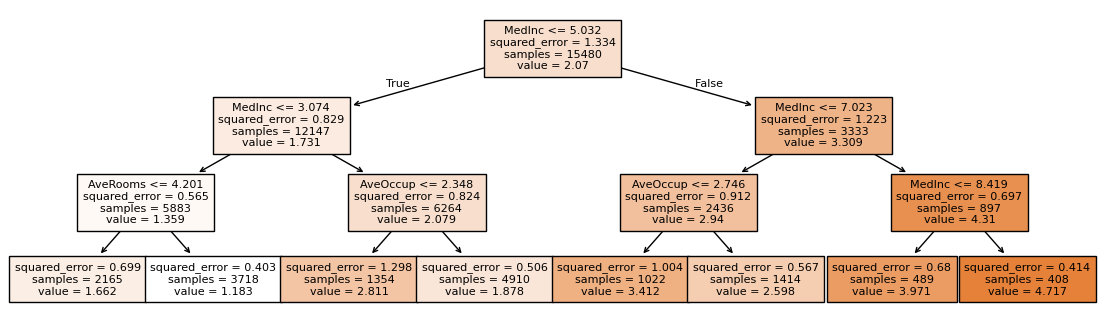

In [ ]:
X_train, X_test, y_train, y_test = get_california_dataset()

decision_tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=0)
decision_tree_regressor.fit(X_train, y_train)

y_pred = decision_tree_regressor.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(f'X: {X_test[0]}, original y: {y_test[0]}, pred. y: {y_pred[0]}')

plt.figure(figsize=(14, 4))
plot_tree(decision_tree_regressor, feature_names=fetch_california_housing().feature_names, fontsize=8, filled=True)
plt.show()

In [ ]:
pd.DataFrame(X_test[0], fetch_california_housing().feature_names).transpose()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01


**<font color='magenta'>Ответ на вопрос </font> (о том как предсказывается значение на объекте):**



Проверяется MedInc, если он, первый параметр, меньше или равен 5.032, что правда, попадаем в левый узел. Деление будет продолжаться до тех пор, пока данные не поделятся на 'чистые' классы, но в нашем случае есть ограничение по глубине дерева, в таком случае я не знаю, полностью ли обрабатываются данные (2 варианта: 1)да, просто условия подбираются не очень правильно, поэтому в конце имеем чистые наборы, но на тесте обвалится, т.к.не те закономерности 2)(менее вероятный) типа дерево оптимальной глубины обрезали, данные недочищены)

Почему MedInc -- атрибут для разбиения? Потому что, как я понимаю, регрессор автоматически посчитал информационный выигрыш, то есть то, насколько каждый  параметр уменьшает неопределённость, и у MedInc значение наибольшее. После того, как он исчерпал свои возможности по разделению, берётся другой атрибут.

По мере прохождения каждого узла уменьшается ошибка:) (в том и суть алгоритма...)

value -- то значение, которое дерево предсказывает для нового примера, попадающего в этот узел

Если глубину большую выбрать, будет переобучение. Воть.

In [ ]:
housing = fetch_california_housing()
X1, y1 = housing.data, housing.target
pd.DataFrame(X1, columns=housing.feature_names).head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


Мы смогли убедиться, что дерево решений действительно строит систему правил, по которым предсказывает цену недвижимости. Также мы можем убедиться, что множество возможных предсказаний регрессора сильно ограничено: все они перечислены в листовых вершинах графа. Но в чем же тогда сила деревьев решений, брат? Давайте разбираться дальше.




## Ансамбли решений

[Теорема Кондорсе о присяжных](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85), переведённая на язык машинного обучения, гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности. Давайте попробуем на простом примере проверить эту теорему.



### <font color='orange'>Задание 2.1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. В этот раз ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [ ]:
def built_tree(X_train, X_test, y_train, y_test, n):
    regr = DecisionTreeRegressor(random_state=n)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    mean_pred = np.array([statistics.mean(y_pred)] * len(y_test))

    print(f'predicted y: {y_pred}')
    print(f'the average prediction: {mean_pred[0]}')
    print(f'MAE of predictions: {mean_absolute_error(y_test, y_pred)}')
    print(f'MAE of mean predictions: {mean_absolute_error(y_test, mean_pred)}')
    print('===')

In [ ]:
X_train, X_test, y_train, y_test = get_california_dataset()

for n in range(1, 4):
    built_tree(X_train, X_test, y_train, y_test, n)

predicted y: [0.425   0.521   5.00001 ... 1.455   1.887   5.00001]
the average prediction: 2.0827977461240312
MAE of predictions: 0.46331883139534885
MAE of mean predictions: 0.9124095171827112
===
predicted y: [0.425   0.693   5.00001 ... 1.455   1.887   5.00001]
the average prediction: 2.082942718992248
MAE of predictions: 0.4645068275193799
MAE of mean predictions: 0.9124373317446367
===
predicted y: [0.425   0.693   5.00001 ... 1.455   1.887   5.00001]
the average prediction: 2.0863146143410853
MAE of predictions: 0.46247640503875975
MAE of mean predictions: 0.9130943993187008
===


Вывод: этот гиперпараметр влияет на качество предсказаний, т.к. он отвечает за разбиение данных. Конкретно в данном случае с ростом этого гиперпараметра улучшилось качество каждого отдельного предсказания, но не усреднённого. Avg предсказание увеличивалось. Почему, я не знаю, просто факт.

Надеюсь, мы смогли убедиться, что это действительно работает. Правда, улучшение достаточно маленькое и для прорыва в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам.

### <font color='orange'>Задание 2.2 (кросс-проверка, 1 балл)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии    
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить RandomForestRegressor. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [ ]:
def random_f(X_train, X_test, y_train, y_test):
    regr = RandomForestRegressor(n_estimators=3, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    mean_pred = np.array([statistics.mean(y_pred)] * len(y_test))

    print(f'predicted y: {y_pred}')
    print(f'the average prediction: {mean_pred[0]}')
    print(f'MAE of predictions: {mean_absolute_error(y_test, y_pred)}')
    print(f'MAE of mean predictions: {mean_absolute_error(y_test, mean_pred)}')
    print('===')

In [ ]:
random_f(X_train, X_test, y_train, y_test)

predicted y: [0.49833333 0.56466667 5.00000667 ... 1.42366667 2.66966667 4.16      ]
the average prediction: 2.081316680878553
MAE of predictions: 0.3910999521963824
MAE of mean predictions: 0.912125624168219
===


**<font color='magenta'>Вывод по результату</font>**: (ВПИШИТЕ СЮДА ТЕКСТОМ)

0.6001895862815657 -- MAE из 1 номера. То есть тут работает значительно лучше (0.3910999521963824).

В 2.1 результаты хуже

Для прорывов и этого, кажется, маловато. Давайте продолжим исследовать случайные леса.

## Переобучение и зависимость предсказаний от числа деревьев

В прошлом задании мы вручную установили число деревьев в лесу равное трем, чтобы более честно сравниваться с нашим предыдущим ансамблем. Давайте изучим влияние этого параметра на результат предсказаний.



### <font color='orange'>Задание 3.1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 3, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

In [ ]:
#Your code here:
def random_f(X_train, y_train, X_test, y_test):
    n_trees = list(map(lambda x: int(x), np.logspace(1, 3, num=10).reshape(10,)))
    tough_times, mae_train, mae_test = [], [], []
    for n in n_trees:
        start = time.time()
        regr = RandomForestRegressor(n_estimators=n, random_state=42)
        regr.fit(X_train, y_train)
        end = time.time()
        non_logic = regr.predict(X_train)
        avg = regr.predict(X_test)
        mae_train.append(mean_absolute_error(y_train, non_logic))
        mae_test.append(mean_absolute_error(y_test, avg))
        tough_times.append(end-start)
    return n_trees, tough_times, mae_train, mae_test

In [ ]:
n_trees, tough_times, mae_train, mae_test = random_f(X_train, y_train, X_test, y_test)

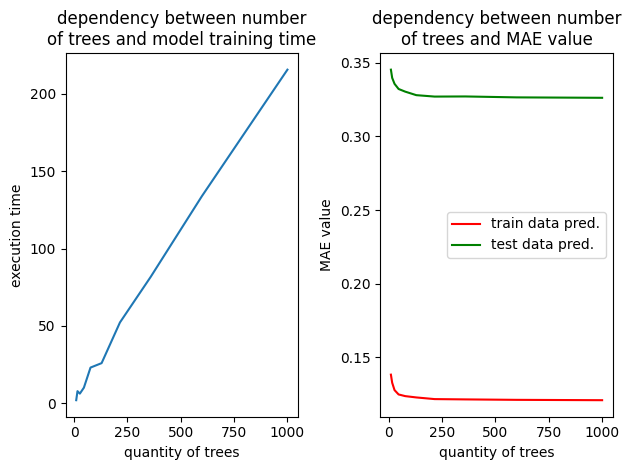

<Figure size 1100x11400 with 0 Axes>

In [ ]:
figure, axis = plt.subplots(1, 2)
plt.figure(figsize=(11, 114))

axis[0].plot(n_trees, tough_times)
axis[0].set_xlabel('quantity of trees')
axis[0].set_ylabel('execution time')
axis[0].set_title("dependency between number\nof trees and model training time")

# Постройте график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси
# Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение
# MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
axis[1].plot(n_trees, mae_train, color='r', label='train data pred.')
axis[1].plot(n_trees, mae_test, color='g', label='test data pred.')
axis[1].set_xlabel('quantity of trees')
axis[1].set_ylabel('MAE value')
axis[1].set_title("dependency between number\nof trees and MAE value")
axis[1].legend()

figure.tight_layout()
plt.show()

**<font color='magenta'>Ваши выводы:</font>**

*Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)*

Чем больше деревьев планируется в ансамбле, тем больше времени нужно для их создания:) Чем больше деревьев, тем ниже ошибка, хотя, начиная, с сотни деревьев, а то и раньше, качество почти не меняется. Видимо, оптимальное кол-во где-то там, около сотни, и лежит (для этих данных).

Переобучение...
С одной стороны, деревьев больше, корреляции меньше -- переобучения меньше, с другой -- выход на ровный график -- признак переобучения. Хнык. Баланс нужен, баланс

Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы уже обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или даже если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать warm_start можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### <font color='orange'>Задание 3.2 (кросс-проверка, 3 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: n_estimators = 100, warm_start = True, random_state=42
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число regressor.n_estimators на 100.
4. Воспользуйтесь методом fit, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не вырастите лес с 1000 деревьями.
6. Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

In [ ]:
#Your code here:
def random_forests(X_train, y_train, X_test, y_test):
    tough_times, quality, q_train = [], [], []
    for i in range(100, 1001, 100):
        start = time.time()
        if i == 100:
            regr = RandomForestRegressor(
                                         n_estimators=i,
                                         warm_start = True,
                                         random_state=42
                                         )
        else:
            regr.n_estimators = i
        regr.fit(X_train, y_train)
        end = time.time()
        tough_times.append(end-start)
        quality.append(mean_absolute_error(y_test, regr.predict(X_test)))
        q_train.append(mean_absolute_error(y_train, regr.predict(X_train)))
    return quality, q_train, tough_times, list(range(100, 1001, 100))


In [ ]:
q, q2, t, n = random_forests(X_train, y_train, X_test, y_test)

Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)


Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

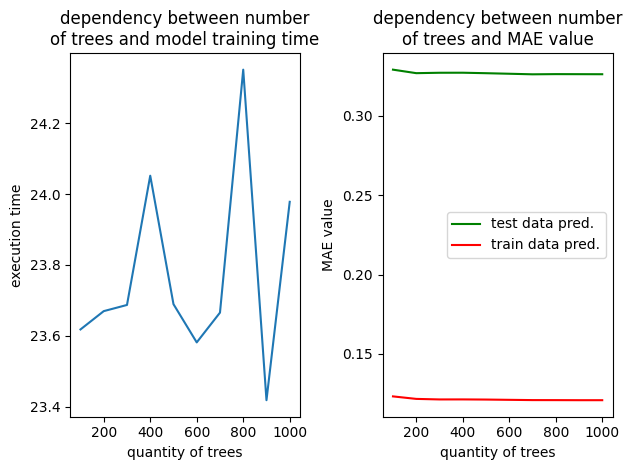

<Figure size 1100x11400 with 0 Axes>

In [ ]:
figure, axis = plt.subplots(1, 2)
plt.figure(figsize=(11, 114))

axis[0].plot(n, t)
axis[0].set_xlabel('quantity of trees')
axis[0].set_ylabel('execution time')
axis[0].set_title("dependency between number\nof trees and model training time")

# Постройте график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси
# Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение
# MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
axis[1].plot(n, q, color='g', label='test data pred.')
axis[1].plot(n, q2, color='r', label='train data pred.')
axis[1].set_xlabel('quantity of trees')
axis[1].set_ylabel('MAE value')
axis[1].set_title("dependency between number\nof trees and MAE value")
axis[1].legend()

figure.tight_layout()
plt.show()

**<font color='magenta'>Ваши выводы:</font>** (ВПИШИТЕ СЮДА ТЕКСТОМ)


## Важность признаков

С этого момента мы изменим датасет и попытаемся поиграться с физикой: возьмем коллекцию различных потенциалов и для них будем предсказывать некоторую физическую величину. Обученные физики говорят, что эта величина зависит от формы и глубины потенциала, а значит и мы можем тут чему-то научиться. Ранее эту задачу пытались решить с помощью сверточных нейронных сетей. А получится ли это у нас с помощью деревьев?

Загрузим датасет и посмотрим как он выглядит:

**<font color='red'>Внимание!</font>** Для выполнения этого задания вам понадобится публичный датасет из задания `Деревья решений (ML)` на cv-gml.ru.

Если вы выполняете задание в <font color='red'>Google Colab</font>, то можете пропустить дальнейший текст - данные скачаются в следующей ячейке кода.

Если вы делаете <font color='red'>локально</font>, то, пожалуйста, выполните эти пункты:

1. Скачайте архив `Шаблон решения` задания `Деревья решений (ML)` и разархивируйте его в любом удобном для вас месте.
2. Найдите переменную `path_to_dataset`, расположенную на первой строке ячейки после загрузки данных, и измените её значение на полный путь до папки `[ПАПКА_ИЗВЛЕЧЕНИЯ]/public_tests/01_test_potentials_input/train/potentials`


In [ ]:
!pip install --upgrade --no-cache-dir gdown # Нужно для возможности скачать zip; Перезапускать ноутбук НЕ НУЖНО!
!gdown 1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv

Downloading...
From (original): https://drive.google.com/uc?id=1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv
From (redirected): https://drive.google.com/uc?id=1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv&confirm=t&uuid=daa3ba40-8fe6-40f6-b404-932bf7ea6bbb
To: /content/trees_public_tests.zip
100% 27.8M/27.8M [00:00<00:00, 35.8MB/s]


**<font color='red'>Внимание!</font> Если Вы выполняете данное задание в google colab и предыдущий код выполнился с ошибкой (файл не скачался), то Вам нужно будет скачать его вручную**.

Для этого:

1. Перейдите по ссылке, указанной этом в сообщении об ошибке.
1. Скачайте файл вручную на локальный компьютер.
1. Нажмите на иконку папки в левой верхней части данного окна.
1. Вручную загрузите файл в корневую директорию (перетащив файл или нажав ПКМ -> загрузить).

In [ ]:
!unzip -d ./public_tests -u trees_public_tests.zip

Archive:  trees_public_tests.zip
   creating: ./public_tests/01_test_potentials_gt/
  inflating: ./public_tests/01_test_potentials_gt/target.json  
   creating: ./public_tests/01_test_potentials_input/
   creating: ./public_tests/01_test_potentials_input/train/
   creating: ./public_tests/01_test_potentials_input/train/potentials/
  inflating: ./public_tests/01_test_potentials_input/train/potentials/0a8c432fef7944bf9f56c5191d8074fe.npz  
  inflating: ./public_tests/01_test_potentials_input/train/potentials/0bc42452c94d493ab94e6d013cd9fecb.npz  
  inflating: ./public_tests/01_test_potentials_input/train/potentials/0fab6fb6c8b84f8da2d536a1fec73912.npz  
  inflating: ./public_tests/01_test_potentials_input/train/potentials/1a8739d04d024541a9b8ef7dc01d5611.npz  
  inflating: ./public_tests/01_test_potentials_input/train/potentials/1e98eec3244d4a4aaaa72ee02b74f028.npz  
  inflating: ./public_tests/01_test_potentials_input/train/potentials/0001f09663374722b1341b1e47f88d24.npz  
  inflating: 

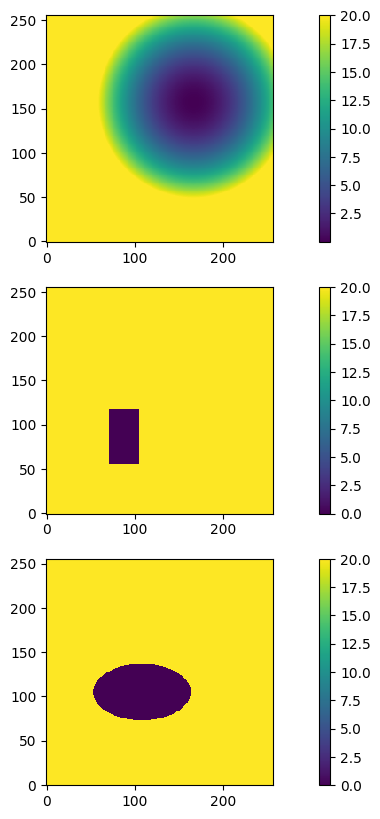

In [ ]:
path_to_dataset = "public_tests/01_test_potentials_input/train/potentials"

chosen_ones = {'b2399918793e4228a3ea0a0a89adf11b.npz', '513d5523d14c47feb8b544138071c496.npz', 'ca9f96c404b740e3b28f583f9d9afbf8.npz'}

plt.figure(figsize=(12, 10))

def get_potential_dataset():

    global path_to_dataset

    """Return the training and testing splits of the potential dataset"""
    X, y = [], []

    plot_index = 1

    if not path_to_dataset.endswith("/"):
        path_to_dataset += "/"

    for f in os.listdir(path_to_dataset):

        npz = np.load(f'{path_to_dataset}{f}')
        data, target = npz['data'], npz['target']

        X.append(data)
        y.append(target)

        if f in chosen_ones:
            plt.subplot(len(chosen_ones), 1, plot_index)
            plt.imshow(data, origin="lower", interpolation='none')
            plt.colorbar()
            plot_index += 1
    plt.show()
    return train_test_split(np.array(X), np.array(y), random_state=42)

X_train, X_test, y_train, y_test = get_potential_dataset()

Можно увидеть, что у нас имеется три типа потенциалов: два с бесконечно крутыми стенками: квадратный и эллиптический (их значение резко меняется на 0). Также у нас имеется гармонический потенциал (красивый и круглый, он плавно спускается к своему минимуму). В местах, где потенциала нет, значение матрицы равно 20.

В глаза бросается одна проблема: матрицы у нас квадратные (каждая картинка `256 х 256`), а большинство методов машинного обучения работает с векторами-признаками. К сожалению, нам придется с этим позже разобраться. Но есть еще более крупная проблема: потенциалы находятся в "случайных" местах рисунка, и оставлять это без внимания нельзя. Но вернёмся к нашим баранам. У линейных регрессоров есть одно очень полезное свойство: после обучения мы ``из коробки`` получаем важность признаков: чем выше значение коэффициента (или абсолютное значение) стоящего у признака, тем этот признак важнее. Деревья решений не обладают столь же ``естественной`` оценкой важности признаков, однако мы всё равно можем её получить. Называется эта оценка критерием Джини: она вычисляет то, как начинают ``ошибаться`` предсказания регрессора, если исключить данный признак. Чем сильнее ошибка, тем важнее признак. К нашей радости, sklearn так же ``из коробки`` включает данные оценки признаков. Давайте попробуем воспользоваться этой функцией и посмотреть на важность признаков.

План наших действий следующий. Во-первых, мы должны преобразовать квадратные матрицы в векторы. Для простоты воспользуемся обычным reshape, что сможет гарантировать нам устойчивость преобразования. Получив вектор, мы воспользуемся методами машинного обучения и получим вектор, характеризующий важность каждого признака. Далее, с целью визуализации этого вектора важностей и возможности его сопоставления с оригинальными изображениями, воспользуемся обратным reshape в исходную размерность. Reshape работает таким образом, что если мы сделаем всё верно, то важности признаков попадут в те же пиксели, которым они соответствуют в исходных изображениях. Давайте попробуем это!

### <font color='orange'>Задание 4.1 (кросс-проверка, 4 балла)</font>
**Данные**: потенциалы  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Воспользоваться классом PotentialTransformer для преобразования двумерной матрицы в одномерный вектор
2. Воспользоваться классом Pipeline, чтобы "объединить" трансформатор и обучаемый метод
3. Обучить LinearSVR из sklearn на этом датасете.
4. Обучить RandomForestRegressor из sklearn на этом датасете.
5. Извлеките важность признаков из обученного леса с помощью `feature_importances_`. Извлеките также коэффициенты svm через coef_ (брать абсолютные значения необязательно).
6. Преобразуйте одномерный вектор важностей признаков в двумерную картинку таким образом, чтобы их можно было сравнивать с исходными потенциалами. Постройте рисунки важностей признаков с помощью plt.imshow. Добавьте легенду.
7. Оцените качество предсказаний через метод .predict.
8. Проанализируйте результаты. Можно ли сказать что у обоих методов получились одинаковые важности признаков? Можно ли сказать, что важность признаков отображает структуру потенциалов?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

In [ ]:
from sklearn import svm

# Извлеките важность признаков из обученного леса с помощью
# feature_importances_. Извлеките также коэффициенты svm через
# coef_ (брать абсолютные значения необязательно).

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

feature_coefficients = svm_model.coef_
for i, coeff in enumerate(feature_coefficients):
    print(f"Feature {i+1}: {coeff}")

In [ ]:
class PotentialTransformer:
    """
    A potential transformer.

    This class is used to convert the potential's 2d matrix to 1d vector of features.
    """

    def fit(self, x, y):
        """
        Build the transformer on the training set.
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: trained transformer
        """
        return self

    def fit_transform(self, x, y):
        """
        Build the transformer on the training set and return the transformed dataset (1d vectors).
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: transformed potentials (list of 1d vectors)
        """
        return self.transform(x)

    def transform(self, x):
        """
        Transform the list of potential's 2d matrices with the trained transformer.
        :param x: list of potential's 2d matrices
        :return: transformed potentials (list of 1d vectors)
        """
        return x.reshape((x.shape[0], -1))


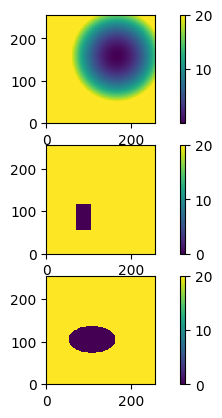

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.00011129 0.0001086  0.00010628 ... 0.00013128 0.00013948 0.00014775]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# Your code here:
# 1. Воспользоваться классом PotentialTransformer для
# преобразования двумерной матрицы в одномерный вектор
# 2. Воспользоваться классом Pipeline, чтобы "объединить"
# трансформатор и обучаемый метод
estimators_svr = Pipeline([
                          ('PotentialTransformer', PotentialTransformer()),
                          ('LinearSVR', LinearSVR(random_state=42))
                          ])
estimators_rfr = Pipeline([
                         ('PotentialTransformer', PotentialTransformer()),
                         ('RandomForestRegressor', RandomForestRegressor(random_state=42))
                         ])
X_train, X_test, y_train, y_test = get_potential_dataset()
# 3 + 5. Обучить LinearSVR из sklearn на этом датасете.
estimators_svr.fit(X_train, y_train)
print(estimators_svr.named_steps['LinearSVR'].coef_)

# 4 + 5. Обучить RandomForestRegressor из sklearn на этом датасете.
estimators_rfr.fit(X_train, y_train)
print(estimators_rfr.named_steps['RandomForestRegressor'].feature_importances_)

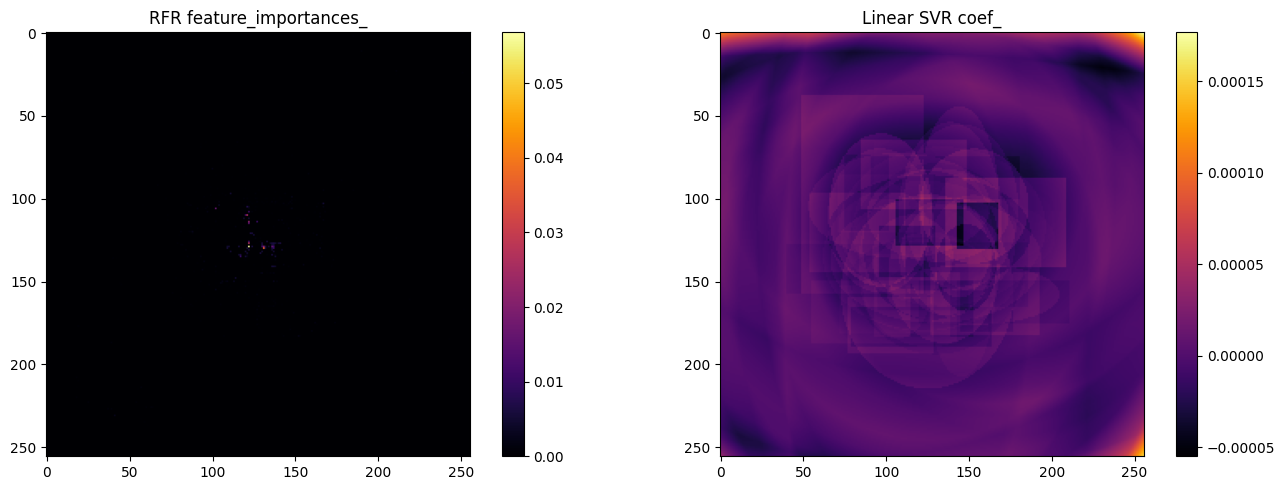

In [ ]:
# 6. Преобразуйте одномерный вектор важностей признаков в
# двумерную картинку таким образом, чтобы их можно было сравнивать
# с исходными потенциалами. Постройте рисунки важностей признаков
# с помощью plt.imshow. Добавьте легенду.

rfr = estimators_rfr.named_steps['RandomForestRegressor'].feature_importances_.reshape((256, 256))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.imshow(rfr, cmap='inferno')
plt.title('RFR feature_importances_')
plt.colorbar()


svr = estimators_svr.named_steps['LinearSVR'].coef_.reshape((256, 256))

plt.subplot(1, 2, 2)
plt.imshow(svr, cmap='inferno')
plt.title('Linear SVR coef_')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# 7. Оцените качество предсказаний через метод .predict.
y_pred_svr = estimators_svr.predict(X_test)
y_pred_rfr = estimators_rfr.predict(X_test)

y_pred_svr_train = estimators_svr.predict(X_train)
y_pred_rfr_train = estimators_rfr.predict(X_train)

mae_svr_train = mean_absolute_error(y_train, y_pred_svr_train)
mae_svr_test = mean_absolute_error(y_test, y_pred_svr)

mae_rfr_train = mean_absolute_error(y_train, y_pred_rfr_train)
mae_rfr_test = mean_absolute_error(y_test, y_pred_rfr)

pd.DataFrame(([mae_svr_train, mae_rfr_train], [mae_svr_test, mae_rfr_test]),
               columns=['svr', 'rfr'], index=['train', 'test'])

# Хорошее качество, ошибки маленькие
# rfr работает значительно лучше, чем svr

,svr,rfr
train,0.071165,0.016571
test,0.136670,0.040681


In [ ]:
# 8. Проанализируйте результаты. Можно ли сказать что у
# обоих методов получились одинаковые важности
# признаков? Можно ли сказать, что важность признаков
# отображает структуру потенциалов?

**<font color='magenta'>Ваши выводы:</font>**

Нет, признаки получились разными, т.к. у svr важности признаков более размытые и плохо показывают структуру потенциалов (в отличие от rfr). Rfr хорошо отображает области с резкими изменениями значений и области минимумов -- точки в центре графика в противовес рандомным (нет) фигурам svr.

В нашем случае rfr больше подходит.

Если всё сделано верно, то в предыдущем задании вы должны были увидеть некоторый сумбур в коэффициентах SVM. Можно увидеть, как некоторые потенциалы "отпечатались" в признаках, т.е. метод явно запомнил ответ, не пытаясь их обобщить. Видимо, нужно каким-то образом "стандартизировать" потенциалы, чтобы было легче "обобщать" их. К примеру, можно попробовать параллельно передвигать потенциал таким образом, чтобы в центре всегда оказывалось минимальное значение (места на матрице, не заполненные потенциалами, заполняются 20). Возможно вы заметите и другие "проблемы" или найдёте более элегантные решения, которые смогут помочь Вам улучшить результат.

**<font color='red'>Внимание!</font>** В этом задании разрешено пользоваться лишь методами, основанными на деревьях решений и их ансамблях (лесах). Пользоваться бустингом лесов нельзя (про них будет отдельное домашнее задание). Со списком лесов, которые реализованы в пакете sklearn.ensemble, можно ознакомиться [тут](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). По описанию метода убедитесь, что бустинг в нём не применяется.

Если ваше обучение проходит непозволительно долго, то, вероятно, лесам не удаётся подобрать хорошее оптимальное разбиение, а значит, вам нужно подумать об ином трансформаторе.

# <font color='orange'>Бонусное задание (2 балла)</font>

Найдите мем про деревья решений/случайные леса лучше, чем этот:

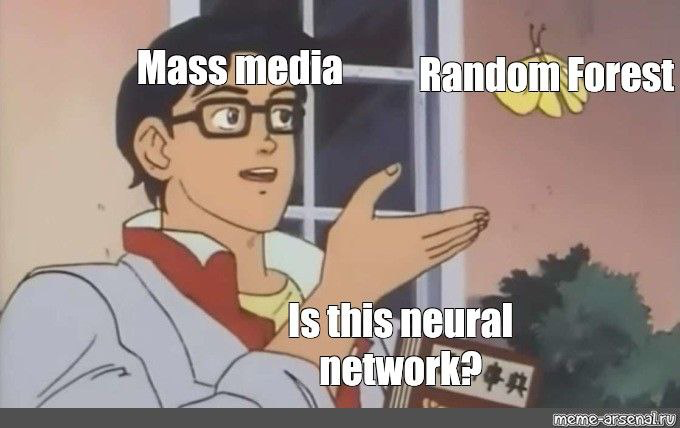

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

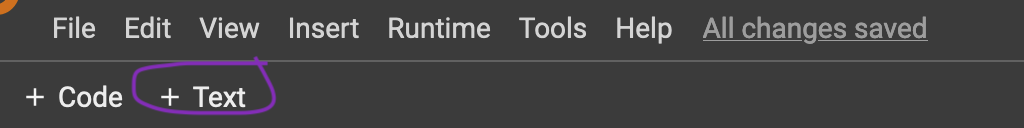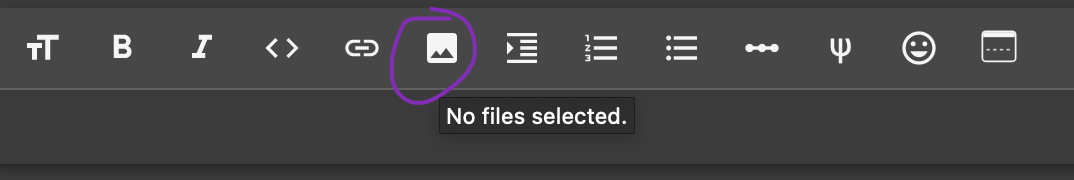

Ну что, детишки. Поздравляю с еще одним выполненным ДЗ!

